# Doppler (Interferometry) Radar

This is a Doppler (interferometry) radar simulation example based on `RadarSimPy`.

>`RadarSimPy` is a radar simulation package built with python. **This package is still under development by myself, and there is no plan to release it yet**.

This notebook is available on my [GitHub](https://github.com/rookiepeng/fmcw-radar-simulation).


## Doppler Radar Model
### Transmitter

The following table lists the basic parameters of the radar transmitter.

| Parameter                       | Variable in `RadarSimPy` | Value      |
|---------------------------------|--------------------------|------------|
| Center frequency ($f_c$)        | fc                       | 24.125 GHz |
| Transmitted power ($P_t$)       | tx_power                 | 10 dBm     |
| Signal length ($T$)             | pulse_length             | 20 s       |

### Receiver
The parameters of the receiver are listed in the table below.

| Parameter                        | Variable in `RadarSimPy` | Value        |
|----------------------------------|--------------------------|--------------|
| Sampling rate ($f_s$)            | fs                       | 44 ksps       |
| Noise figure ($NF$)              | noise_figure             | 12 dB        |
| RF gain/loss ($G_{rf}$)          | rf_gain                  | 20 dB        |
| Load resistor ($R_L$)            | load_resistor            | 500 $\Omega$ |
| Baseband voltage gain ($G_{BB}$) | baseband_gain            | 30 dB        |
| Baseband bandwidth ($B_{BB}$)    | bandwidth                | 0.8 MHz      |


In [1]:
tx = dict(
    fc=24.125e9,
    tx_power=10,
    pulse_length=20,
)
rx = dict(
    fs=20,
    noise_figure=12,
    rf_gain=20,
    baseband_gain=30,
    load_resistor=500,
    bandwidth=0.8e6,
)

### Transmitter antenna
The radiation pattern os the transmitter antenna is $\cos{\theta}$. The gain of the antenna is 6 dB.

In [2]:
import numpy as np

angle = np.arange(-90, 91, 1)
pattern = 20 * np.log10(np.cos(angle / 180 * np.pi) + 0.01) + 6

tx_antenna = dict(
    location=(0, 0, 0),
    azimuth_angle=angle,
    azimuth_pattern=pattern,
    elevation_angle=angle,
    elevation_pattern=pattern,
)
tx['array'] = [tx_antenna]

### Receiver antenna
The radiation pattern os the receiver antenna is $\cos{\theta}$. The gain of the antenna is 6 dB.

In [3]:
rx_antenna = dict(
    location=(0, 0, 0),
    azimuth_angle=angle,
    azimuth_pattern=pattern,
    elevation_angle=angle,
    elevation_pattern=pattern,
)
rx['array'] = [rx_antenna]

Create the FMCW radar model based on all the parameters defined above.

In [4]:
from radarsimpy.Radar import Radar

radar = Radar(transmitter=tx, receiver=rx)

### Targets
The propertities of targets are defined here. There are 3 targets in this simulation. The locations of the targets are defined through $(x, y, z)$ coordinates in meters, and the speeds of the targets are defined trough $(v_x, v_y, v_z)$ in $m/s$. The propertites of the targets also includes radar cross-section (RCS (dBsm)) and phase (radian).

In [5]:
target_1 = dict(location=(0, '10+1e-3*math.sin(2*math.pi*1*t)', 0), speed=(0, 0, 0), rcs=20, phase=0)

targets = [target_1]

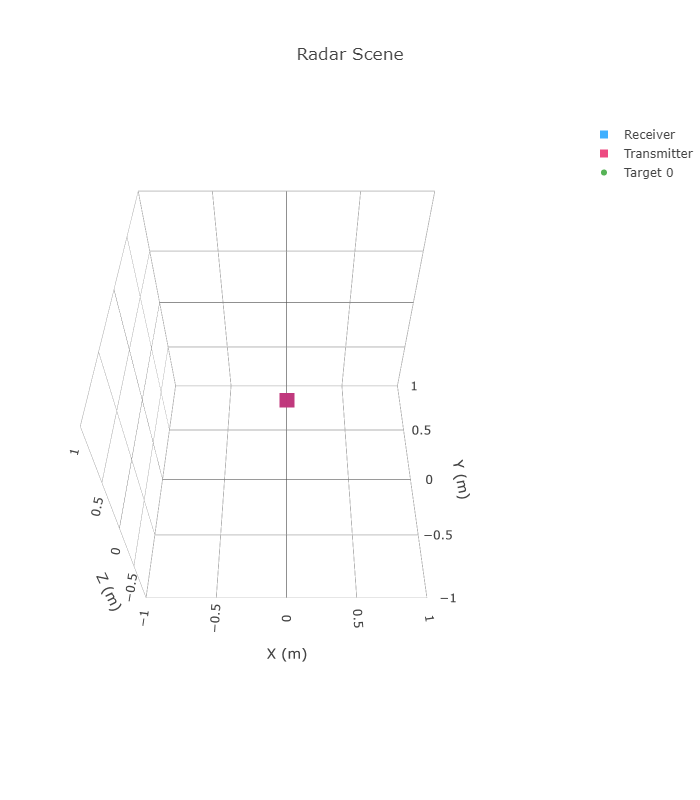

In [6]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from plotly import tools

init_notebook_mode(connected=True)

rx_loc_x = np.zeros(len(rx['array']))
rx_loc_y = np.zeros(len(rx['array']))
rx_loc_z = np.zeros(len(rx['array']))
for rx_idx, rx_element in enumerate(rx['array']):
    rx_loc_x[rx_idx] = rx_element['location'][0]
    rx_loc_y[rx_idx] = rx_element['location'][1]
    rx_loc_z[rx_idx] = rx_element['location'][2]

tx_loc_x = np.zeros(len(tx['array']))
tx_loc_y = np.zeros(len(tx['array']))
tx_loc_z = np.zeros(len(tx['array']))
for tx_idx, tx_element in enumerate(tx['array']):
    tx_loc_x[tx_idx] = tx_element['location'][0]
    tx_loc_y[tx_idx] = tx_element['location'][1]
    tx_loc_z[tx_idx] = tx_element['location'][2]

rx_axis = go.Scatter3d(
    x=rx_loc_x,
    y=rx_loc_y,
    z=rx_loc_z,
    mode='markers',
    name='Receiver',
    marker=dict(
        color='rgb(17, 157, 255)', size=8, opacity=0.8, symbol='square'),
)

tx_axis = go.Scatter3d(
    x=tx_loc_x,
    y=tx_loc_y,
    z=tx_loc_z,
    mode='markers',
    name='Transmitter',
    marker=dict(
        color='rgb(233, 30, 99)', size=8, opacity=0.8, symbol='square'),
)

data = [rx_axis, tx_axis]

for target_idx, target in enumerate(targets):
    target_loc = go.Scatter3d(
        x=[target['location'][0]],
        y=[target['location'][1]],
        z=[target['location'][2]],
        mode='markers',
        name='Target ' + str(target_idx),
        marker=dict(size=6, opacity=0.8),
    )
    data = data + [target_loc]

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=0, y=-1.5, z=1.8),
)

layout = go.Layout(
    title='Radar Scene',
    scene=dict(
        xaxis=dict(title='X (m)'),
        yaxis=dict(title='Y (m)'),
        zaxis=dict(title='Z (m)'),
        camera=camera,
        aspectmode='cube',
    ),
    margin=dict(l=0, r=0, b=120, t=120),
    #     legend=dict(orientation='h'),
    height=800,
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='radar_scene.html')

## Simulate Baseband Beat Signals

Calculate baseband signal matrix:
$$[channels, pulses, ADC~samples]$$

In [7]:
import radarsimpy.simulator as sim

data = sim.run_simulator(radar, targets)
time_matrix = data['time']
data_matrix = data['data']

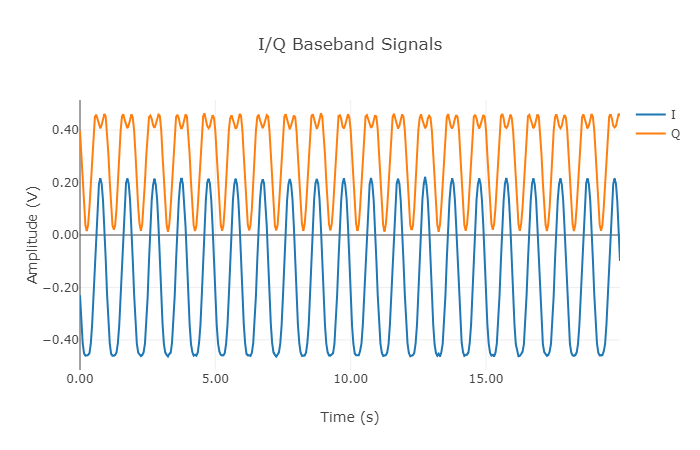

In [8]:
beat_I = go.Scatter(
    x=time_matrix[0, 0, :],
    y=np.real(data_matrix[0, 0, :]),
    name='I',
)
beat_Q = go.Scatter(
    x=time_matrix[0, 0, :],
    y=np.imag(data_matrix[0, 0, :]),
    name='Q',
)
data = [beat_I, beat_Q]

layout = go.Layout(
    title='I/Q Baseband Signals',
    yaxis=dict(tickformat='.2f', title='Amplitude (V)'),
    xaxis=dict(tickformat='.2f', title='Time (s)'),
)

fig = go.Figure(data, layout=layout)
iplot(fig, filename='beat.html')

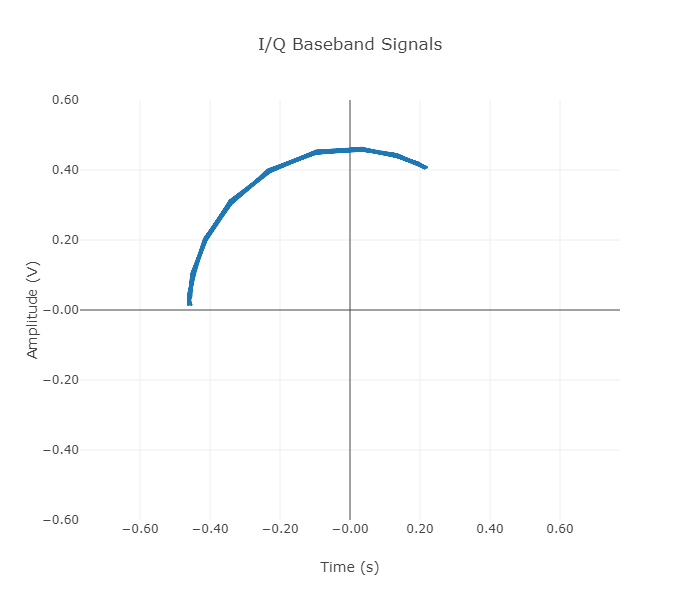

In [9]:
polar = go.Scatter(
    x=np.real(data_matrix[0, 0, :]),
    y=np.imag(data_matrix[0, 0, :]),
    #name='I',
)

data = [polar]

layout = go.Layout(
    title='I/Q Baseband Signals',
    xaxis=dict(range=[-0.6, 0.6], tickformat='.2f', title='Time (s)'),
    yaxis=dict(range=[-0.6, 0.6], tickformat='.2f', title='Amplitude (V)',scaleanchor="x", scaleratio=1),
    height=600,
    width=600,
)

fig = go.Figure(data, layout=layout)
iplot(fig, filename='beat.html')

## Radar Signal Processing